<a href="https://colab.research.google.com/github/Sumukh-Bharadvaja/AIT_736_Project/blob/main/Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 # For image operations
import random # for shuffling
from matplotlib import pyplot as plt, cm
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
!pip install -q kaggle

!pip install imblearn # install imblearn library for data balancing

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d meetnagadia/kvasir-dataset  # Download the dataset
!unzip -q kvasir-dataset.zip -d dataset

100% 1.15G/1.15G [00:18<00:00, 93.3MB/s]
100% 1.15G/1.15G [00:18<00:00, 67.6MB/s]


In [6]:
dataset_path = 'dataset/kvasir-dataset'
classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
           'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

In [9]:
class_images = {class_name: [] for class_name in classes}

In [7]:
def load_images_from_folder(class_name, n=400, image_size=(150, 150)):
    folder_path = os.path.join(dataset_path, class_name)
    images = []
    # Get the list of image file names
    filenames = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    # Load the images
    for filename in tqdm(filenames[:n], desc=f'Loading {class_name}'):
        img = cv2.imread(filename)  # By default, OpenCV reads images in BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalizing the image
        images.append(img)  # Do not flatten
    return images

In [10]:
for class_name in classes:
    class_images[class_name] = load_images_from_folder(class_name)

Loading ulcerative-colitis: 100%|██████████| 400/400 [00:04<00:00, 88.26it/s]


In [11]:
dyed_lifted_polyps = class_images['dyed-lifted-polyps']
dyed_resection_margins = class_images['dyed-resection-margins']
esophagitis=class_images['esophagitis']
normal_cecum=class_images['normal-cecum']
normal_pylorus=class_images['normal-pylorus']
normal_z_line=class_images['normal-z-line']
polyps=class_images['polyps']
ulcerative_colitis=class_images['ulcerative-colitis']

In [12]:
np.random.seed(150) # Random seed to control the randomness of generated values
data = np.array(dyed_lifted_polyps + dyed_resection_margins + esophagitis + normal_cecum  + normal_pylorus + normal_z_line + polyps + ulcerative_colitis)  # Combining the list of images
labels = np.array([0]*400 + [1]*400 +[2]*400 +[3]*400 +[4]*400 +[5]*400 +[6]*400 +[7]*400) # creating class labels for the image classes
length = data.shape[0] # length of the data

# Shuffling the data and labels
indx = np.arange(length)
np.random.shuffle(indx)

data = data[indx]
labels = labels[indx]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=150, test_size=0.3, stratify=labels, shuffle=True)

In [15]:
y_test

array([7, 5, 3, 6, 4, 5, 0, 2, 4, 5, 6, 1, 5, 0, 3, 3, 4, 0, 7, 2, 4, 3,
       0, 7, 5, 7, 4, 4, 5, 5, 1, 6, 1, 6, 2, 3, 5, 2, 0, 2, 6, 0, 0, 6,
       0, 2, 3, 5, 2, 1, 4, 3, 5, 3, 3, 2, 6, 2, 1, 7, 7, 2, 7, 4, 0, 2,
       1, 3, 3, 0, 0, 7, 4, 3, 2, 4, 5, 6, 3, 4, 5, 5, 0, 1, 7, 6, 7, 4,
       3, 4, 6, 2, 2, 2, 5, 0, 3, 2, 0, 4, 0, 0, 3, 4, 3, 4, 2, 1, 7, 4,
       1, 4, 1, 0, 1, 0, 1, 5, 7, 7, 0, 1, 6, 4, 7, 6, 7, 0, 3, 1, 2, 2,
       3, 3, 2, 0, 7, 0, 3, 2, 1, 5, 1, 5, 7, 2, 4, 6, 4, 4, 7, 2, 3, 0,
       4, 1, 7, 2, 6, 3, 0, 7, 2, 3, 5, 4, 4, 2, 1, 1, 4, 3, 1, 5, 6, 5,
       4, 5, 4, 1, 6, 1, 1, 4, 0, 2, 6, 2, 7, 2, 2, 0, 6, 3, 1, 3, 4, 6,
       5, 1, 5, 4, 5, 1, 1, 6, 7, 0, 4, 7, 6, 1, 2, 0, 4, 2, 3, 6, 0, 2,
       6, 7, 6, 4, 2, 6, 1, 3, 0, 1, 6, 0, 5, 0, 2, 3, 5, 1, 6, 2, 0, 5,
       5, 4, 7, 0, 3, 3, 3, 1, 0, 6, 0, 3, 2, 1, 5, 0, 4, 6, 0, 6, 5, 2,
       0, 2, 7, 3, 6, 3, 2, 2, 4, 7, 3, 2, 1, 6, 7, 7, 0, 7, 6, 7, 1, 3,
       1, 5, 3, 6, 1, 1, 0, 7, 7, 7, 2, 7, 6, 7, 6,

## **One hot encoding**
- Since the categories has class vectors we would be converting them to binary class matrices using one-hot encoding

In [16]:
y_train_one = to_categorical(y_train)
y_test_one=to_categorical(y_test)

In [18]:
y_test_one

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [15]:
number_of_classes = 8

# Create the model
model_mobileNet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')  # Final layer with softmax activation for 'n' classes
])

In [16]:
model_mobileNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 3493320 (13.33 MB)
Trainable params: 26445

In [17]:
model_mobileNet.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [18]:
history_mobileNet = model_mobileNet.fit(X_train, y_train_one,
                                        batch_size=32,
                                        epochs=10,  # Adjust number of epochs as necessary
                                        validation_data=(X_test, y_test_one))

Epoch 1/10
70/70 [==============================] - 57s 787ms/step - loss: 1.0755 - accuracy: 0.6357 - val_loss: 0.5081 - val_accuracy: 0.8115
Epoch 2/10
70/70 [==============================] - 53s 766ms/step - loss: 0.5339 - accuracy: 0.7826 - val_loss: 0.4223 - val_accuracy: 0.8292
Epoch 3/10
70/70 [==============================] - 56s 807ms/step - loss: 0.3874 - accuracy: 0.8576 - val_loss: 0.3775 - val_accuracy: 0.8385
Epoch 4/10
70/70 [==============================] - 85s 1s/step - loss: 0.3617 - accuracy: 0.8647 - val_loss: 0.4092 - val_accuracy: 0.8333
Epoch 5/10
70/70 [==============================] - 52s 751ms/step - loss: 0.2925 - accuracy: 0.8741 - val_loss: 0.3756 - val_accuracy: 0.8521
Epoch 6/10
70/70 [==============================] - 54s 778ms/step - loss: 0.2424 - accuracy: 0.9094 - val_loss: 0.3912 - val_accuracy: 0.8281
Epoch 7/10
70/70 [==============================] - 47s 670ms/step - loss: 0.2448 - accuracy: 0.9085 - val_loss: 0.3723 - val_accuracy: 0.8406
Ep

In [19]:
test_loss, test_accuracy = model_mobileNet.evaluate(X_test, y_test_one)
print(f'Test Accuracy: {test_accuracy}')

30/30 [==============================] - 14s 465ms/step - loss: 0.3763 - accuracy: 0.8552
Test Accuracy: 0.8552083373069763


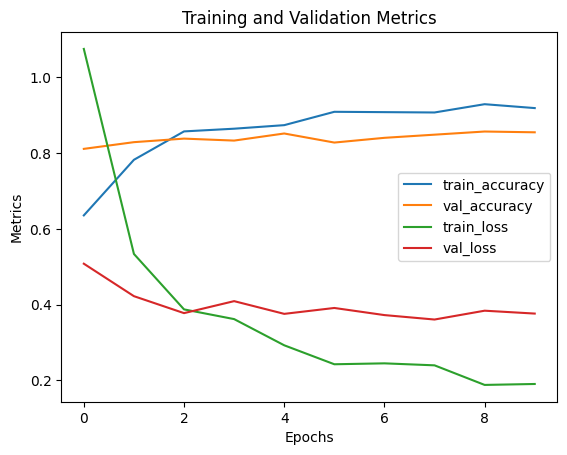

In [20]:
plt.plot(history_mobileNet.history['accuracy'], label='train_accuracy')
plt.plot(history_mobileNet.history['val_accuracy'], label='val_accuracy')
plt.plot(history_mobileNet.history['loss'], label='train_loss')
plt.plot(history_mobileNet.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

In [21]:
y_pred_proba_mobileNet = model_mobileNet.predict(X_test)
y_pred_mobileNet = np.argmax(y_pred_proba_mobileNet, axis=1)
y_true_mobileNet = np.argmax(y_test_one, axis=1)

30/30 [==============================] - 14s 442ms/step


In [22]:

precision_mobileNet = precision_score(y_true_mobileNet, y_pred_mobileNet, average='macro')
recall_mobileNet = recall_score(y_true_mobileNet, y_pred_mobileNet, average='macro')

print(f'Precision (MobileNet): {precision_mobileNet}')
print(f'Recall (MobileNet): {recall_mobileNet}')

Precision (MobileNet): 0.854424313139589
Recall (MobileNet): 0.8552083333333333


This models seems to be performing better for given dataset as it reduces the training and validation loss significantly.

Moreover the training accuracy is almost similar to the validation accuracy as well.

Conducting stratified cross validation would give us more insights on the model on overfitting.

In [24]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional layers of the MobileNet model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of MobileNet
model_mobilnet_sgd = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')  # Make sure 'number_of_classes' is set correctly
])

# Hyperparameters
batch_size = 50
epochs = 10
learn_rate = 0.001

# Initialize the SGD optimizer
sgd_optimizer = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# Compile the model
model_mobilnet_sgd.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_mobilnet_sgd_best.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history_mobilnet_sgd = model_mobilnet_sgd.fit(
    X_train, y_train_one,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test_one),
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best weights (optional)
model_mobilnet_sgd.load_weights('model_mobilnet_sgd_best.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model_mobilnet_sgd.evaluate(X_test, y_test_one)
print(f'Test Accuracy with SGD: {test_accuracy:.4f}')

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 2.1236 - accuracy: 0.3969
Epoch 1: val_loss improved from inf to 0.79108, saving model to model_mobilnet_sgd_best.h5
45/45 [==============================] - 63s 1s/step - loss: 2.1236 - accuracy: 0.3969 - val_loss: 0.7911 - val_accuracy: 0.7219
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.8652 - accuracy: 0.6884
Epoch 2: val_loss improved from 0.79108 to 0.59784, saving model to model_mobilnet_sgd_best.h5
45/45 [==============================] - 55s 1s/step - loss: 0.8652 - accuracy: 0.6884 - val_loss: 0.5978 - val_accuracy: 0.7885
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.7388
Epoch 3: val_loss improved from 0.59784 to 0.53399, saving model to model_mobilnet_sgd_best.h5
45/45 [==============================] - 56s 1s/step - loss: 0.6922 - accuracy: 0.7388 - val_loss: 0.5340 - val_accuracy: 0.8094
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7768
Epoch 4: val_loss improved from 0.53399 to 0.49165, saving model to model_mobilnet_sgd_best.h5
45/45 [==============================] - 56s 1s/step - loss: 0.6005 - accuracy: 0.7768 - val_loss: 0.4916 - val_accuracy: 0.8115
Epoch 5/10
45/45 [==============================] - ETA: 